In [1]:
import numpy as np
import pandas as pd
import spacy
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,ConfusionMatrixDisplay,confusion_matrix,accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from mlxtend.plotting import plot_confusion_matrix
import pickle

In [2]:
df=pd.read_csv('/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv')

In [3]:
df.isna().sum()

text             0
label            0
prompt_name      0
source           0
RDizzl3_seven    0
dtype: int64

In [4]:
df['text'].duplicated().sum()

0

In [5]:
tfidf=TfidfVectorizer(max_df=0.8,min_df=0.2,ngram_range=(1,2))
tfidf_data=tfidf.fit_transform(df['text']).toarray()

In [6]:
X_train,X_test,y_train,y_test=train_test_split(tfidf_data,df['label'],test_size=0.2,stratify=df['label'])

In [7]:
print(f"{X_train.shape}:{y_train.shape}")
print(f"{X_test.shape}:{y_test.shape}")

(35894, 160):(35894,)
(8974, 160):(8974,)


In [8]:
gnb=GaussianNB()
gnb.fit(X_train,y_train)
ypred=gnb.predict(X_test)
print(f"accuracy on train data: {gnb.score(X_train,y_train)}")
print("Classification report on test data")
print(classification_report(y_test,ypred))
print(f"Accuracy on test data: {accuracy_score(y_test,ypred)}")

accuracy on train data: 0.8795341839861816
Classification report on test data
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      5474
           1       0.83      0.86      0.85      3500

    accuracy                           0.88      8974
   macro avg       0.87      0.87      0.87      8974
weighted avg       0.88      0.88      0.88      8974

Accuracy on test data: 0.8777579674615557


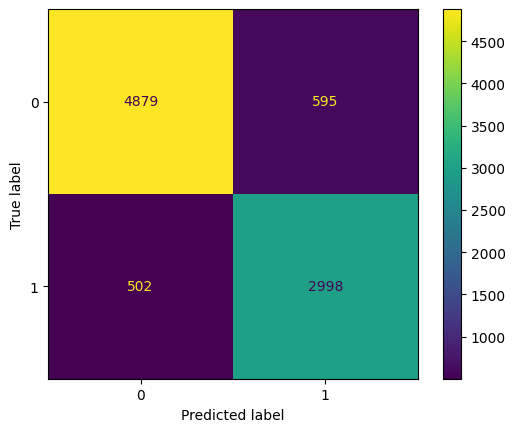

In [9]:
ConfusionMatrixDisplay(confusion_matrix(y_test,gnb.predict(X_test))).plot()

In [10]:
svm=SVC()
svm.fit(X_train,y_train)
y_pred=svm.predict(X_test)
print(f"accuracy on train data: {svm.score(X_train,y_train)}")
print("Classification report on test data")
print(classification_report(y_test,y_pred))
print(f"Accuracy on test data: {accuracy_score(y_test,y_pred)}")

accuracy on train data: 0.9921713935476681
Classification report on test data
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      5474
           1       0.98      0.97      0.98      3500

    accuracy                           0.98      8974
   macro avg       0.98      0.98      0.98      8974
weighted avg       0.98      0.98      0.98      8974

Accuracy on test data: 0.9807220860262982


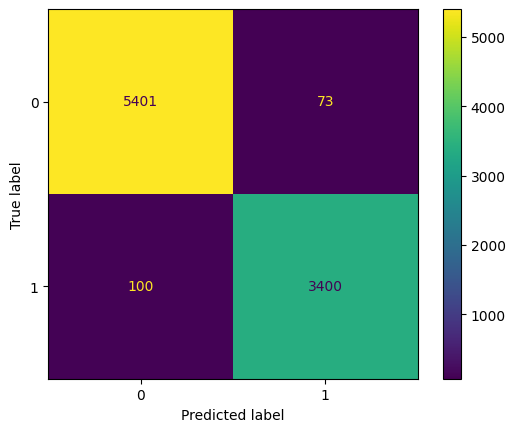

In [11]:
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred)).plot()

accuracy on train data: 0.9457290912130161
Classification report on test data
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      5474
           1       0.93      0.93      0.93      3500

    accuracy                           0.94      8974
   macro avg       0.94      0.94      0.94      8974
weighted avg       0.94      0.94      0.94      8974

Accuracy on test data: 0.9435034544238913


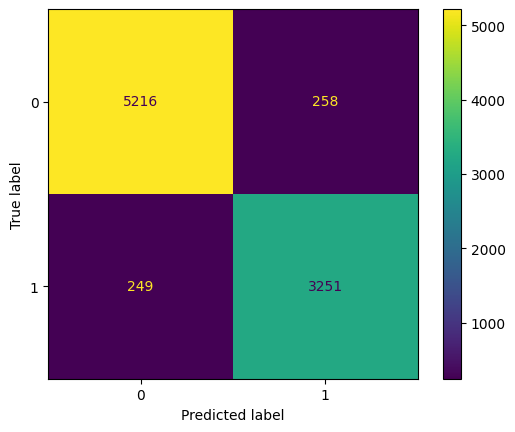

In [12]:
lr=LogisticRegression()
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)
print(f"accuracy on train data: {lr.score(X_train,y_train)}")
print("Classification report on test data")
print(classification_report(y_test,y_pred))
print(f"Accuracy on test data: {accuracy_score(y_test,y_pred)}")
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred)).plot()

accuracy on train data: 0.9608848275477796
Classification report on test data
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      5474
           1       0.95      0.94      0.94      3500

    accuracy                           0.96      8974
   macro avg       0.95      0.95      0.95      8974
weighted avg       0.96      0.96      0.96      8974

Accuracy on test data: 0.9563182527301092


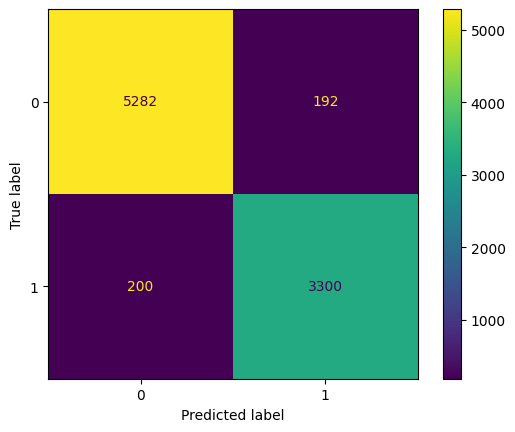

In [13]:
from sklearn.ensemble import VotingClassifier
clf1=GaussianNB()
clf2=SVC()
clf3=LogisticRegression()
vclf=VotingClassifier(estimators=[('nb',clf1),('svm',clf2),('lr',clf3)],voting='hard',n_jobs=-1)
vclf.fit(X_train,y_train)
print(f"accuracy on train data: {vclf.score(X_train,y_train)}")
print("Classification report on test data")
ypred=vclf.predict(X_test)
print(classification_report(y_test,ypred))
print(f"Accuracy on test data: {accuracy_score(y_test,ypred)}")
ConfusionMatrixDisplay(confusion_matrix(y_test,ypred)).plot()

In [25]:
import tensorflow as tf
model=tf.keras.Sequential([
    tf.keras.layers.Dense(128,activation='relu',input_shape=(X_train.shape[1],)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1,activation='sigmoid')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)])

Epoch 1/50
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9148 - loss: 0.2023 - val_accuracy: 0.9696 - val_loss: 0.0822
Epoch 2/50
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9694 - loss: 0.0833 - val_accuracy: 0.9759 - val_loss: 0.0706
Epoch 3/50
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9756 - loss: 0.0679 - val_accuracy: 0.9734 - val_loss: 0.0769
Epoch 4/50
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9812 - loss: 0.0542 - val_accuracy: 0.9764 - val_loss: 0.0700
Epoch 5/50
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9861 - loss: 0.0397 - val_accuracy: 0.9777 - val_loss: 0.0683
Epoch 6/50
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9884 - loss: 0.0334 - val_accuracy: 0.9760 - val_loss: 0.0715
Epoch 7/50
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9889 - loss: 0.0310 - val_accuracy: 0.9809 - val_loss: 0.0680
Epoch 8/50
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9908 - loss: 0.0262 - 

In [26]:
def plot_roc_curve(model,data,y):
    yhat=model.predict(data)
    fpr, tpr, thresholds = roc_curve(y, yhat)
    gmeans = np.sqrt(tpr * (1-fpr))
    ix = np.argmax(gmeans)
    print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
      # plot the roc curve for the model
    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label='Model')
    plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
      # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
      # show the plot
    plt.show()

In [29]:
def plot_confusionmatrix(model,data,y,threshold_value):
    probs=model.predict(data)
    labels=1*(probs>threshold_value)
    CM=confusion_matrix(y,labels)
    fig,ax=plot_confusion_matrix(CM,figsize=(4,4))
    plt.show()

In [38]:
def print_various_metrics(model,data1,data2,threshold):
  probs=model.predict(data1)
  labels=probs>threshold
  print(classification_report(data2,labels))

281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Best Threshold=0.500646, G-Mean=0.979


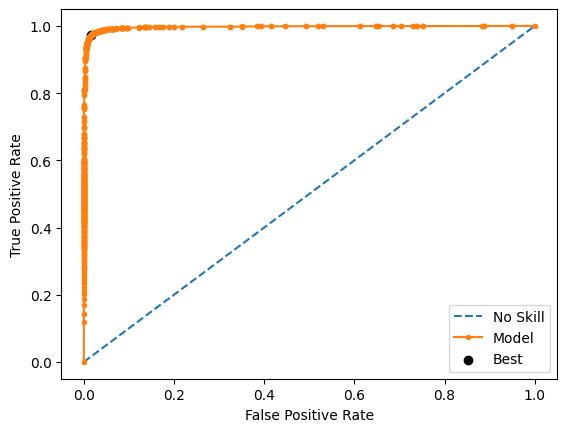

In [28]:
plot_roc_curve(model,X_test,y_test)

281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


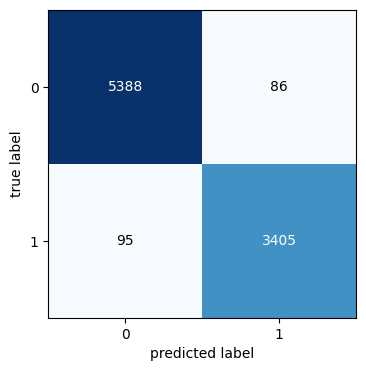

In [30]:
plot_confusionmatrix(model,X_test,y_test,0.500646)

In [39]:
print_various_metrics(model,X_test,y_test,0.500646)

281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      5474
           1       0.98      0.97      0.97      3500

    accuracy                           0.98      8974
   macro avg       0.98      0.98      0.98      8974
weighted avg       0.98      0.98      0.98      8974



In [40]:
print_various_metrics(model,X_train,y_train,0.500646)

1122/1122 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21897
           1       1.00      1.00      1.00     13997

    accuracy                           1.00     35894
   macro avg       1.00      1.00      1.00     35894
weighted avg       1.00      1.00      1.00     35894



In [41]:
probs=model.predict(X_test)
ypred=probs>0.500646
print(f"Accuracy on test data: {accuracy_score(y_test,ypred)}")

281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy on test data: 0.9798306217963004


In [42]:
probs=model.predict(X_train)
ypred=probs>0.500646
print(f"Accuracy on test data: {accuracy_score(y_train,ypred)}")

1122/1122 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Accuracy on test data: 0.9980776731487156


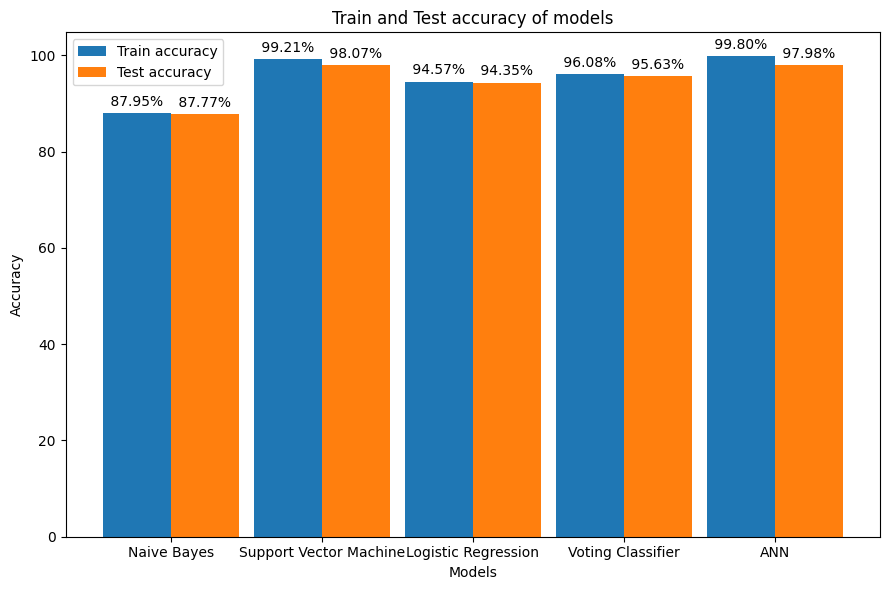

In [5]:
models=['Naive Bayes','Support Vector Machine','Logistic Regression','Voting Classifier','ANN']
category=['Training accuracy','Test accuracy']

values1=[80.48,80.40]
values2=[97.61,97.08]
values3=[86.86,86.82]
values4=[89.94,89.77]

t_val=[87.95,99.21,94.57,96.08,99.80]
t_val2=[87.77,98.07,94.35,95.63,97.98]
x=np.arange(len(models))
width=0.45
fig,ax=plt.subplots(figsize=(9,6))
bars1 = ax.bar(x - width/2, t_val, width, label="Train accuracy")
bars2 = ax.bar(x + width/2, t_val2, width, label="Test accuracy")


ax.set_xlabel("Models")
ax.set_ylabel('Accuracy')
ax.set_title('Train and Test accuracy of models')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

for bar in [bars1,bars2]:
    for b in bar:
        height=b.get_height()
        ax.annotate(f" {height:.2f}% ",xy=(b.get_x()+b.get_width()/2,height),xytext=(0,3),textcoords="offset points",ha="center",va="bottom")

fig.tight_layout()

plt.show()

In [55]:
with open('tfidf_vectorizer.pkl','wb') as f:
    pickle.dump(tfidf,f)

In [56]:
with open('gnb.pkl','wb') as f:
    pickle.dump(gnb,f)

In [57]:
with open('svm.pkl','wb') as f:
    pickle.dump(svm,f)

In [58]:
with open('vclf.pkl','wb') as f:
    pickle.dump(vclf,f)

In [59]:
model.save('ANN.h5')